In [1]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'NGC 1156'

# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\NGC 1156\n1156u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\NGC 1156\n1156B.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\NGC 1156\n1156u.fits")
light_v = light_file_v[0].data

box_u = (120 , 120)
box_b = (180 , 180)
box_v = (150 , 150)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b),np.shape(light_v))

(966, 986) (966, 986) (966, 986)


(966, 986) ((966, 986), (966, 986))


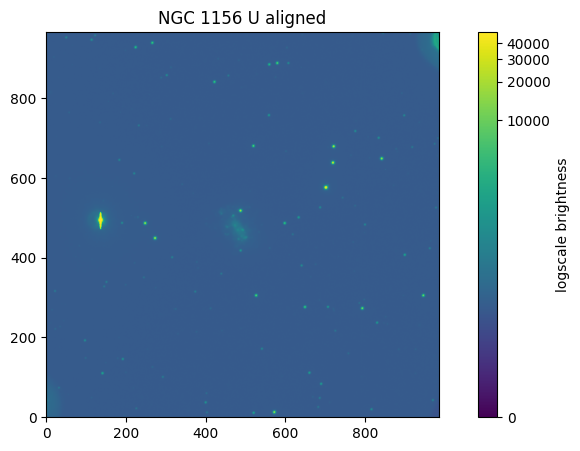

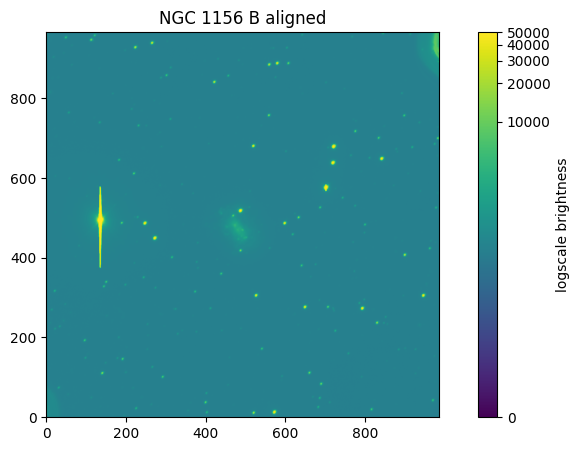

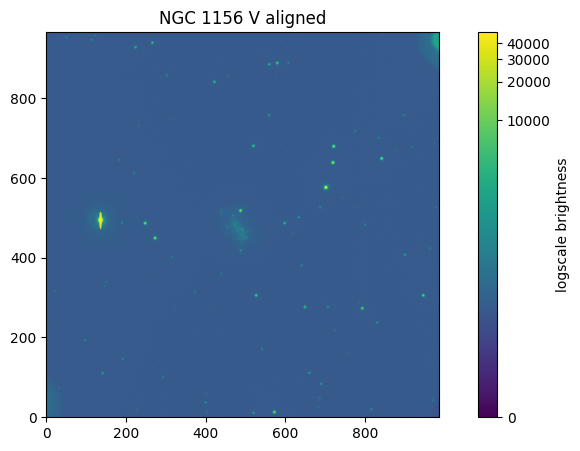

In [2]:
import astroalign as aa
target_fixed = lights[0].byteswap().newbyteorder('N')
source_fixed_1 = lights[1].byteswap().newbyteorder('N')
source_fixed_2 = lights[2].byteswap().newbyteorder('N')
registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [lights[0],registered_image_1, registered_image_2 ]
print(np.shape(list_of_aligned_images[0]),(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2])))
aligned = list_of_aligned_images
for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

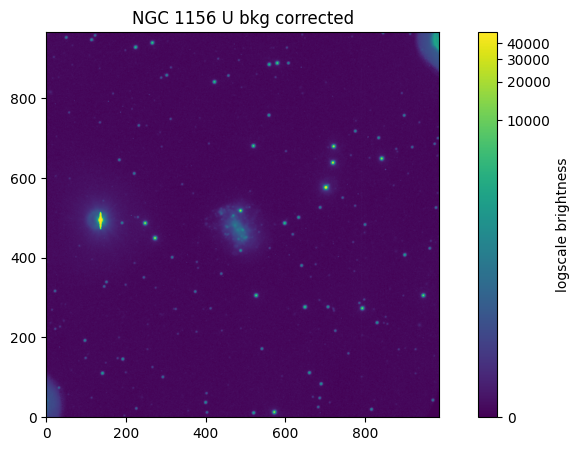

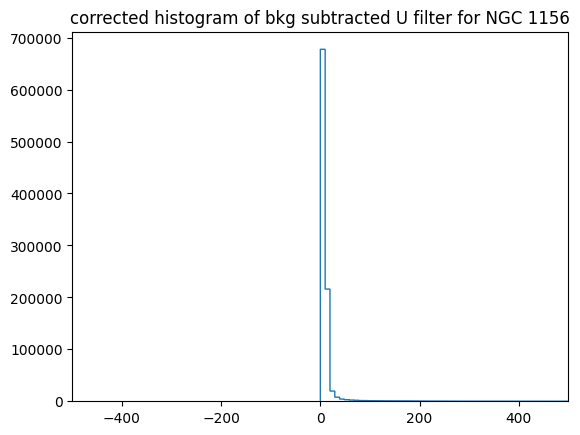

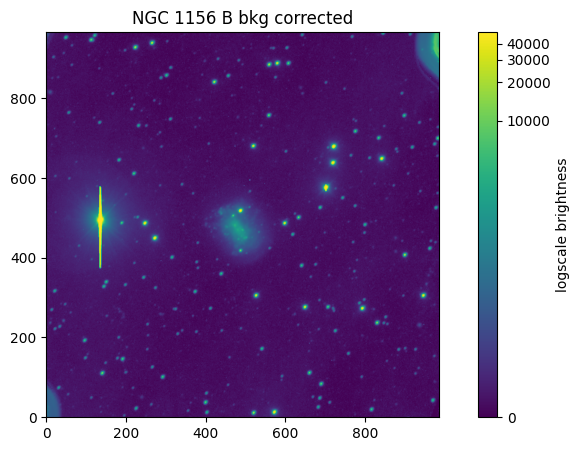

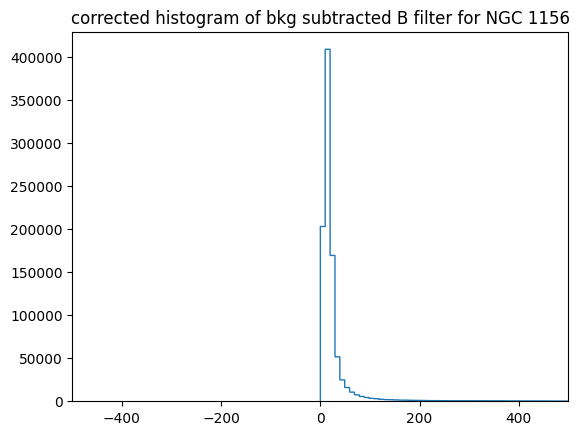

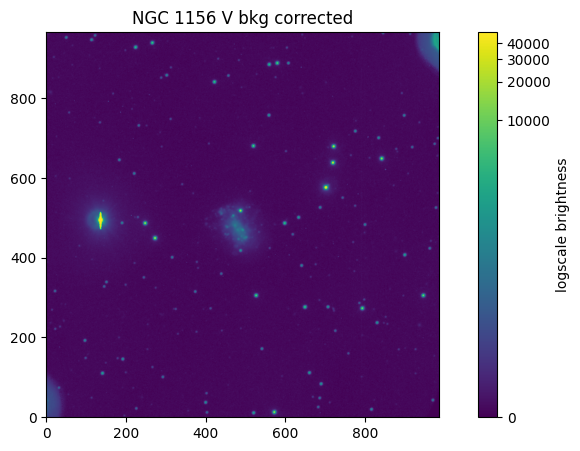

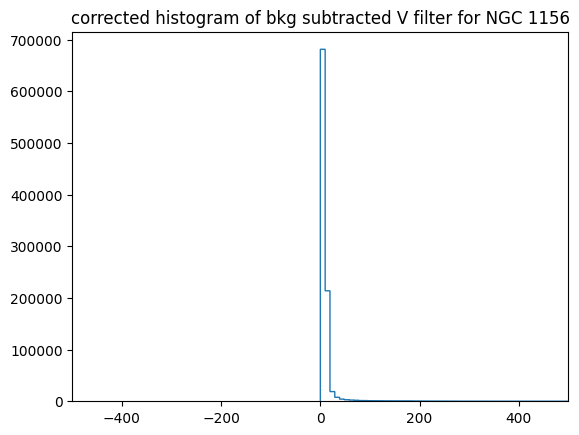

In [3]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

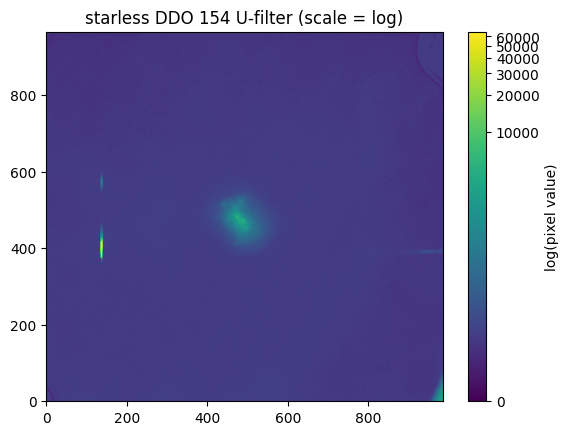

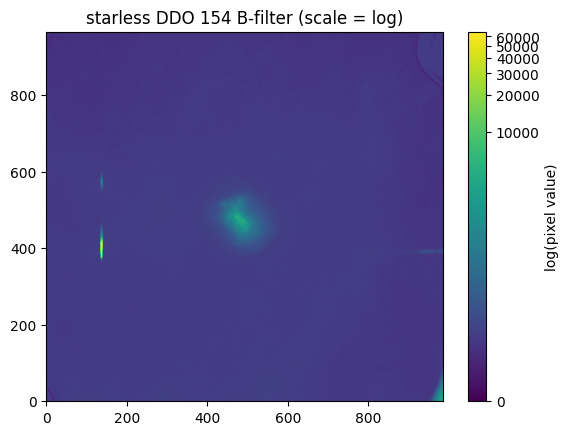

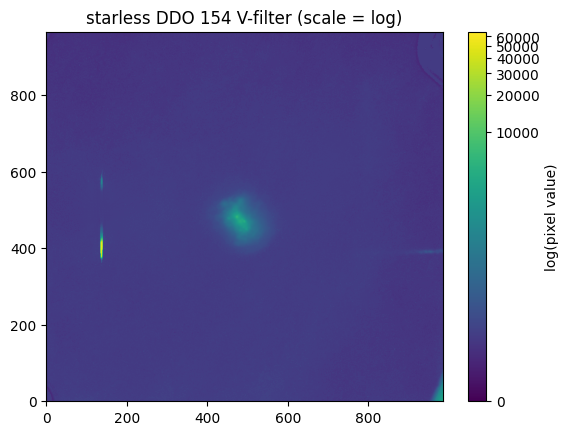

In [4]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\NGC1156\starless_backgroundless_n1156.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\NGC1156\starless_backgroundless_n1156.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\NGC1156\starless_backgroundless_n1156.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

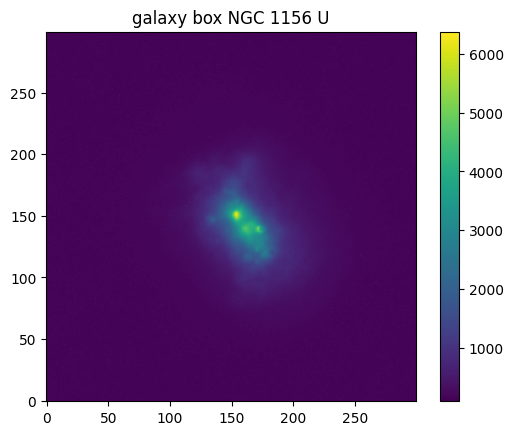

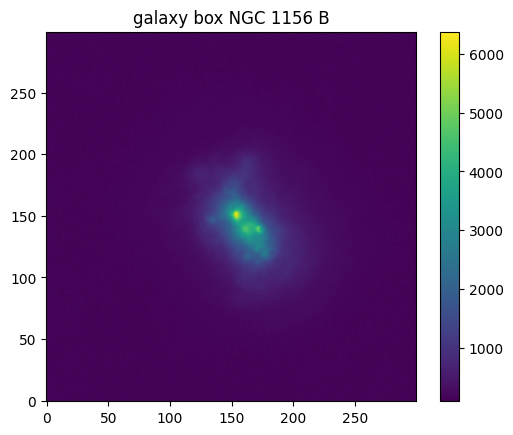

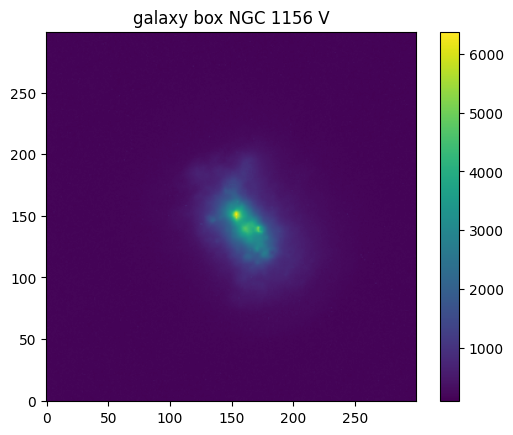

In [5]:
import little_things_functions as ltf
#galaxy_boxes = ltf.get_boxes(starless,[450,470],300)

box_size_x = 150
box_size_y = 150


galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][480 - box_size_y : 480 + box_size_y, 470 - box_size_x : 470 + box_size_x]
        galaxy_boxes.append(box)
        
for i in range(0,3):
    plt.imshow(galaxy_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    

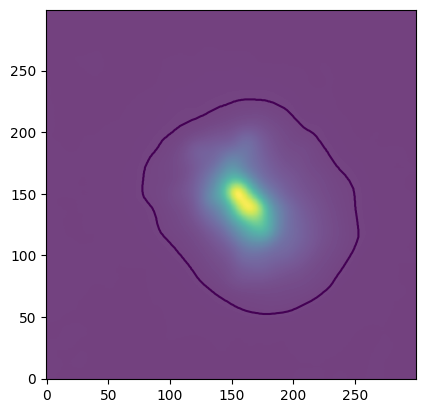

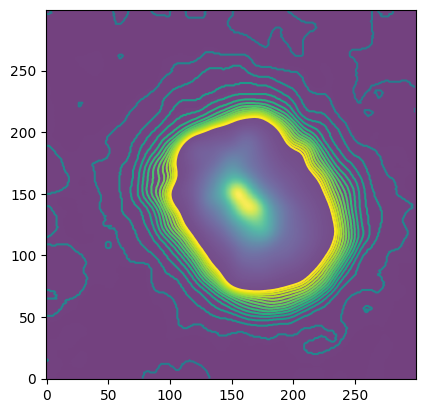

In [6]:
v_value_box = galaxy_boxes[2]
contour_points = ltf.contour_lines_coordinates(v_value_box, 5, [200])
x_points , y_points = contour_points
plt.show()

levels = np.asanyarray(np.arange(50, 300, 10))
ltf.contour_lines(v_value_box, 5, levels)
plt.show()

(145.74984529558083, 155.42160604168447)
[167.84679729 140.34209064  76.24015055  91.79729546 -11.81052092]


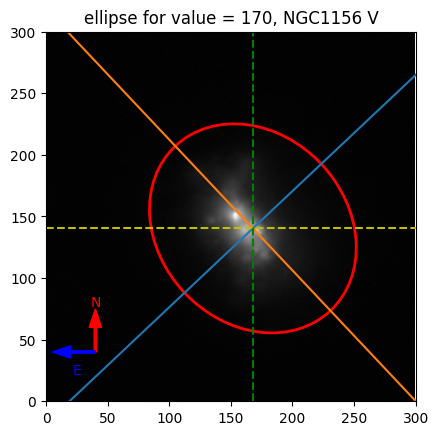

what we measure 43.307 
paper = 41.7 


In [7]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)
m = np.tan(theta)
x_ax = np.arange(0,400)
Y_ax = m*(x_ax-xc) + yc
ax.plot(x_ax,Y_ax)

Y_prime_ax = (-1/m)*(x_ax-xc) + yc
ax.plot(x_ax,Y_prime_ax)

plt.axhline(y=yc, color='y', linestyle='--', label='Semi-Major Axis')
plt.axvline(x=xc,  color='g', linestyle='--', label='Semi-Minor Axis')

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 30, DDO168 V")
# Show the plot
# Example: Add arrows for north and east
plt.arrow(x=40, y=40, dx=0, dy=20, color='red', width=2, head_width=10)
plt.arrow(x=40, y=40, dx=-20, dy=0, color='blue', width=2, head_width=10)
plt.text(40, 80, 'N', color='red', fontsize=10, ha='center', va='center')
plt.text(25, 25, 'E', color='blue', fontsize=10, ha='center', va='center')
# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for value = 170, NGC1156 V")
# Show the plot
plt.show()
angle_in_degrees = np.degrees(theta)
print("what we measure 43.307 ")
print("paper = 41.7 ")

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14320\2198534869.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


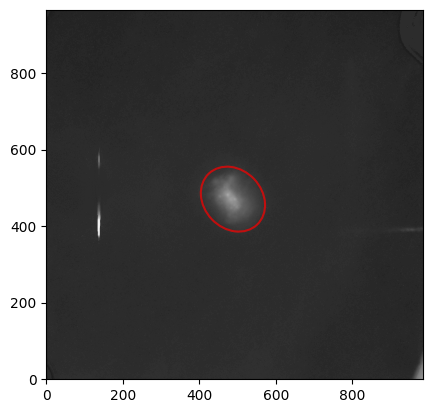

In [8]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
box_center = [480,470]
elliptical_center_box = (xc,yc)
new_xc = xc + (box_center[1]-box_size_x)
new_yc = yc + (box_center[0]-box_size_y)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(starless[2], cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(starless[2], ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14320\4117985913.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_14320\4117985913.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


Aperture sums: [1.2528671502516095e-08, 36426.57269797765, 146673.76705207006, 326699.6522406171, 557088.4986592995, 827618.4585676534, 1130061.317320502, 1463881.6444331333, 1830779.735806235, 2229866.65444557, 2650822.2632057136, 3074893.8452966893, 3489906.538549967, 3900451.9963863594, 4307610.252823508, 4707412.412046532, 5094815.2010023, 5468666.961325036, 5830478.049727301, 6184937.232684081, 6535822.623060469, 6880603.401217692, 7216418.568356296, 7543315.2607041625, 7861844.48860457, 8172468.101914879, 8474764.149861185, 8769321.538354293, 9057599.501526468, 9337617.508977657, 9610446.440527096, 9874846.92248369, 10131891.926182546, 10382793.10774419, 10627131.707352584, 10863624.938946351, 11093410.400780402, 11315064.263559014, 11529292.471341472, 11737203.423191458, 11938958.24678205, 12135131.329141866, 12326935.000973534, 12517066.466245763, 12704681.131774101, 12890127.3516572, 13073578.06401018, 13254916.690336784, 13434909.102651203, 13612997.614835126, 13789864.731450

Text(0.5, 1.0, ' curve of growth for DDO126')

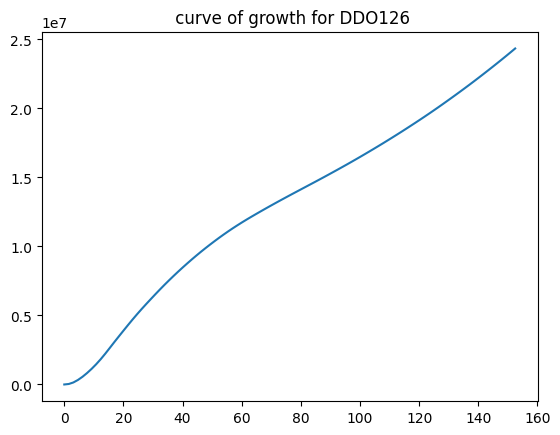

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
a_list = np.linspace(0, 2 * a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(starless[2], cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(starless[2], ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO126")

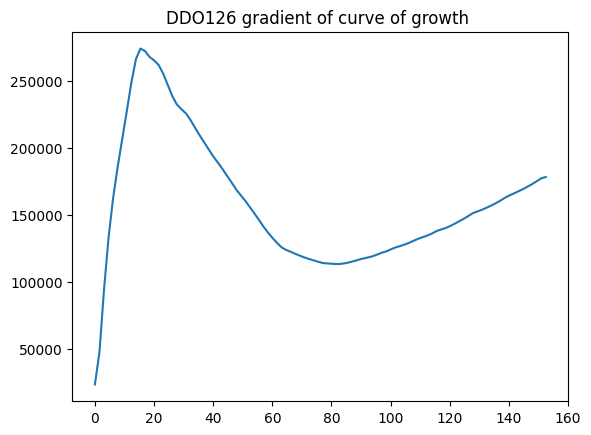

Minimum after peak: 113479.10320603102 at index 53


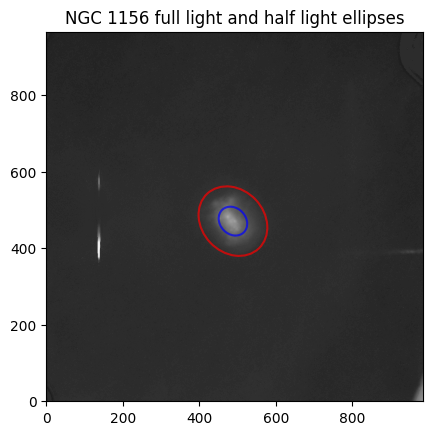

galaxy parameter a =  81.63086827044192 and galaxy parameter b =  98.28801331684602
14315395.362254418
galaxy half light a =  33.88451135754193 and galaxy half light b =  40.798797980577596
7216418.568356296
0.8305271977295205


In [10]:
gradient_sum = np.gradient(sum_values, a_list)
plt.plot(a_list, gradient_sum)
plt.title( "DDO126 gradient of curve of growth ")
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)

peak_index = peaks[0]

min_after_peak = np.min(gradient_sum[peak_index + 1:])

min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

print(f"Minimum after peak: {min_after_peak} at index {min_index_after_peak}")

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio

whole_galaxy = sum_values[min_index_after_peak]

half_light_estimated = whole_galaxy/2
half_light_index = min(range(len(sum_values)), key=lambda i: abs(sum_values[i] - half_light_estimated))
a_half_light = a_list[half_light_index]
b_half_light = a_half_light * ba_ratio

ellipse_aper_full_light = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
ellipse_aper_half_light = EllipticalAperture(elliptical_center, a_half_light, b_half_light, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(starless[2], cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper_full_light.plot(color='red', lw=1.5, alpha=0.7) 
ellipse_aper_half_light.plot(color='blue', lw=1.5, alpha=0.7)
plt.title("%s full light and half light ellipses" %(galaxy_name))
plt.show()

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " ,galaxy_parameter_a * ba_ratio )
print(sum_values[min_index_after_peak])
print("galaxy half light a = ", a_half_light, "and galaxy half light b = " , b_half_light)
print(sum_values[half_light_index])

ratio = sum_values[half_light_index]/whole_galaxy
print(ab_ratio)

In [12]:
pixel_scale = 1.134
D = 7.8

a_half_light_arcsec = a_half_light * pixel_scale
RV_half = (D * a_half_light_arcsec)/206265

print("RV1/2 for DDO69 is: ", RV_half*(10**3), "kpc")
print("paper value is 1.43 kpc")
a_kpc = 1.43
a_half_paper = (a_kpc *206265)/(D*pixel_scale*10**3)
print("a_half_paper_pixels", a_half_paper)

RV1/2 for DDO69 is:  1.4530593162181167 kpc
paper value is 1.43 kpc
a_half_paper_pixels 33.346781305114646


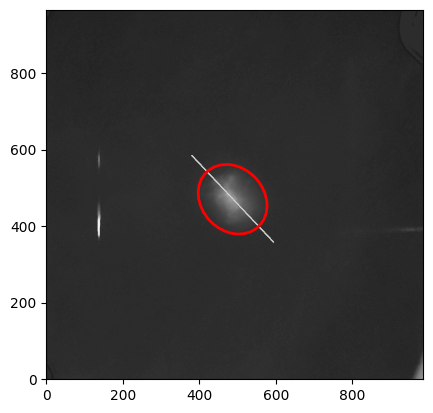

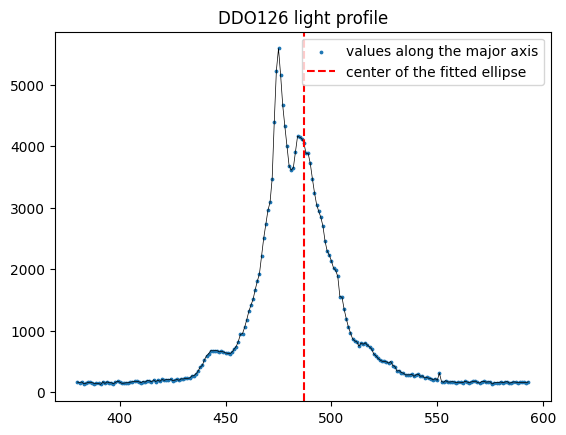

In [84]:
new_xc = int(new_xc)
new_yc = int(new_yc)
x_ax_left = np.arange(380, new_xc)
x_ax_right = np.arange(new_xc, (new_xc-380)+new_xc)
import copy
duplicated_array = copy.copy(starless[2])
def get_line_values(array, yc, x_ax):
    values = []
    for x in x_ax:
        y = int(-1/m * (x) + yc - (-1/m)*new_xc)
        values.append(array[y, x])
        duplicated_array = copy.copy(array)
        array[y, x] = 65535
            
    return values

norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.figure()
ax = plt.gca()
values_along_line_left = get_line_values(starless[2], new_yc, x_ax_left)
values_along_line_right = get_line_values(starless[2], new_yc, x_ax_right)

# Display the other image
ax.imshow(starless[2], cmap='gray' , origin = "lower", norm = norm)
angle_in_degrees = np.degrees(theta)
# Create the ellipse
ellipse = Ellipse(xy=(new_xc, new_yc), width=2*galaxy_parameter_a, height=2*galaxy_parameter_b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
# Add the ellipse to the axis
ax.add_patch(ellipse)
plt.show()
values_along_line = values_along_line_left + values_along_line_right
   
x_ax = np.arange(np.min(x_ax_left), np.max(x_ax_right)+1)
plt.scatter(x_ax , values_along_line, s = 3, label='values along the major axis')
plt.plot(x_ax , values_along_line, color = "black" , linewidth = 0.5)
plt.axvline(x=new_xc, color='r', linestyle='--', label='center of the fitted ellipse')
plt.legend()
plt.title("DDO126 light profile")
plt.show()

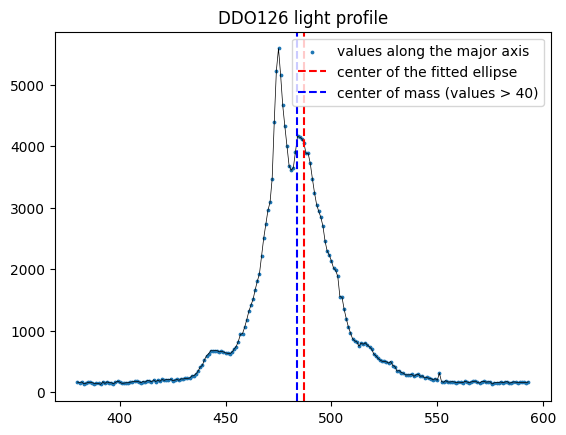

Center of mass of data points with values larger than 40: 483


In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming values_along_line_left and values_along_line_right are already defined
values_along_line = values_along_line_left + values_along_line_right
values_along_line = np.array(values_along_line)  # Convert to NumPy array
x_ax = np.arange(np.min(x_ax_left), np.max(x_ax_right) + 1)

# Get the data points with values larger than 100
mask = values_along_line > 40
values_above_100 = values_along_line[mask]
x_above_100 = x_ax[mask]

# Calculate the center of mass
center_of_mass = np.sum(x_above_100 * values_above_100) / np.sum(values_above_100)

# Plotting the data
plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
plt.axvline(x=new_xc, color='r', linestyle='--', label='center of the fitted ellipse')
plt.axvline(x=center_of_mass, color='b', linestyle='--', label='center of mass (values > 40)')
plt.title("DDO126 light profile")
plt.legend()
plt.show()
center_of_mass = int(center_of_mass)
# Print the center of mass
print("Center of mass of data points with values larger than 40:", center_of_mass)


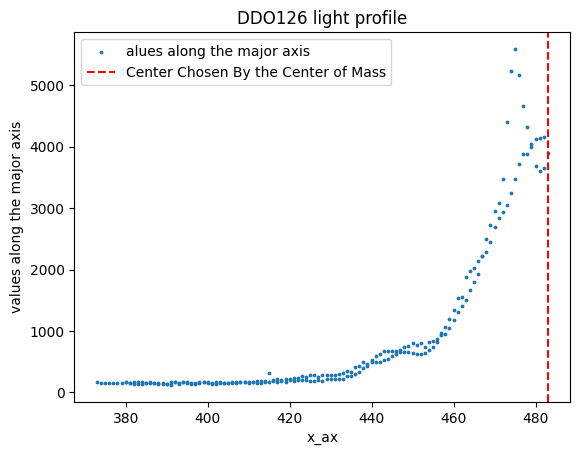

In [86]:
# Initialize the new lists
x_ax_left = []
x_ax_right = []
values_along_line_left = []
values_along_line_right = []

# Split the lists based on center_of_mass
for x, y in zip(x_ax, values_along_line):
    if x < center_of_mass:
        x_ax_left.append(x)
        values_along_line_left.append(y)
    else:
        x_ax_right.append(x)
        values_along_line_right.append(y)
x_ax_mirrored = x_ax_left + [2 * center_of_mass - x for x in x_ax_right]
values_along_line_mirrored = values_along_line_left + values_along_line_right

# Plotting
plt.scatter(x_ax_mirrored, values_along_line_mirrored, s = 3,label='alues along the major axis')
plt.axvline(x=center_of_mass, color='red', linestyle='--', label='Center Chosen By the Center of Mass')
plt.xlabel('x_ax')
plt.ylabel('values along the major axis')
plt.title('DDO126 light profile')
plt.legend()
plt.show()

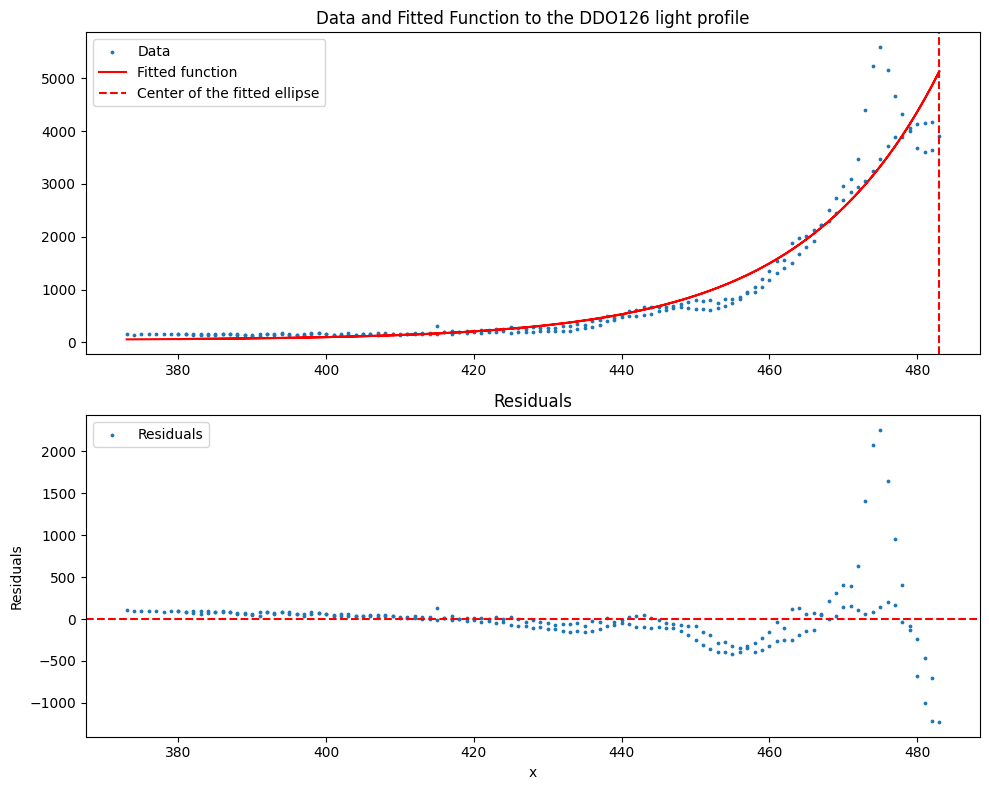

Exponential fit function is a * exp(b * (x - x0)) + c
a is 0.0000 +/- 0.0000
b is 0.0545 +/- 0.0024
c is 46.1966 +/- 40.0478
x0 is -0.3087 +/- 36080.4348
b is 0.0545 +/- 0.0024
1/b is 18.3378


In [87]:
def exponential_func(x, a, b, c, x0):
    return a * np.exp(b * (x - x0)) + c

# Provide initial guesses for the parameters
initial_guesses = [45, 0.1, 25, 0]
popt, pcov = curve_fit(exponential_func, x_ax_mirrored, values_along_line_mirrored, p0=initial_guesses)

# Plot the original data and the fitted function
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.scatter(x_ax_mirrored, values_along_line_mirrored, s=3, label='Data')
plt.plot(x_ax_mirrored, exponential_func(x_ax_mirrored, *popt), label='Fitted function', color='red')
plt.axvline(x=center_of_mass, color='r', linestyle='--', label='Center of the fitted ellipse')
plt.legend()
plt.title('Data and Fitted Function to the DDO126 light profile')

# Calculate residuals
residuals = values_along_line_mirrored - exponential_func(x_ax_mirrored, *popt)

# Plot the residuals
plt.subplot(2, 1, 2)
plt.scatter(x_ax_mirrored, residuals, s=3, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Residuals')
plt.xlabel('x')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Calculate the standard deviation errors on the parameters
perr = np.sqrt(np.diag(pcov))
print("Exponential fit function is a * exp(b * (x - x0)) + c")
print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")

print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
print(f"1/b is {1/popt[1]:.4f}")


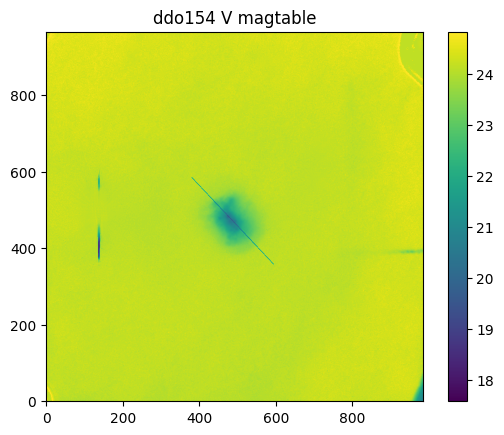

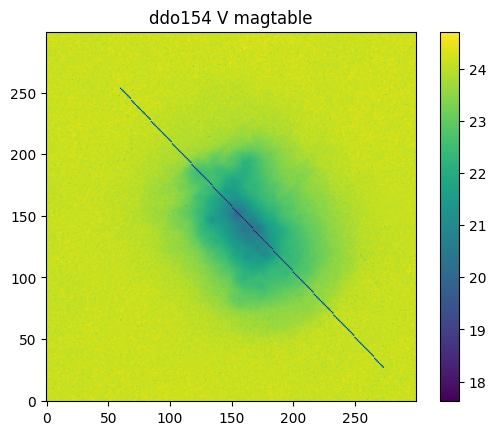

In [88]:
airmass_values=[1.08, 1.00, 1.04]
pixel_scale = 1.134
exposures = [1800, 1800, 1200]
mU_values = [5.203, 0.5026113, -0.0911, 0.]
mB_values = [33.668, 0.2268837, -0.0274, 0.]
mV_values = [3.246, 0.1149137, -0.0167, 0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

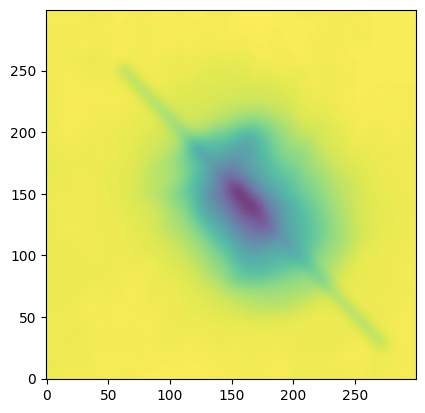

In [89]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [27])
x_points , y_points = contour_points

In [90]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(149.62835074623317, 149.30645122742996)


In [91]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 27, DDO154 V")
# Show the plot
plt.show()

ValueError: max() iterable argument is empty